In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [2]:
with open('./plots/experiment_data.json') as f:
    data = json.load(f)

In [3]:
experiments = {}
for experiment in data:
    experiments.setdefault(experiment['experiment'], []).append(experiment)

In [4]:
experiments.keys()

dict_keys(['1000-steps', 'compare-methods', 'compare-methods-5-corr', '100-steps', '50-steps', 'n-samples-per-structure', 'n-steps'])

In [5]:
experiments['50-steps']

[{'experiment': '50-steps',
  'filepath': '../50-steps/n-samples-per-structure/pos-only-10-samples/pos-only-10-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-10__baseline/pos-only-10-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-10__baseline_df_results.csv',
  'save_prefix': 'pos-only-10-samples',
  'params': {'N_structures': '-1',
   'N_steps': '50',
   'coordinates_snr': '0.2',
   'n_corrector_steps': '1',
   'batch_size': '500',
   'N_samples_per_structure': '10'},
  'predictor_corrector': 'baseline_df_results',
  'correctly_matched': 90.31007751937985,
  'correctly_matched_relaxed': 91.21447028423772},
 {'experiment': '50-steps',
  'filepath': '../50-steps/n-samples-per-structure/TD-5-samples/TD-5-samples_N_structures--1__N_steps-50__coordinates_snr-0.2__n_corrector_steps-1__batch_size-500__N_samples_per_structure-5__new-timesteps/TD-5-sam

## Compare methods

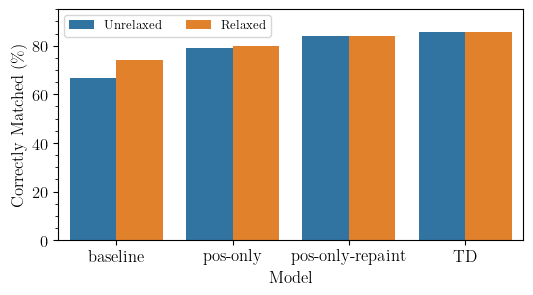

In [19]:
plt.figure(figsize=(6, 3))

comp_labels = [
    *[exp['save_prefix'] for exp in experiments['compare-methods']],
    *[exp['save_prefix'] for exp in experiments['compare-methods-5-corr']],
]

style = [
    *[exp['params']['n_corrector_steps'] for exp in experiments['compare-methods']],
    *[exp['params']['n_corrector_steps'] for exp in experiments['compare-methods-5-corr']],
]

comp_matched_wo_relax = [
    *[exp['correctly_matched'] for exp in experiments['compare-methods']],
    *[exp['correctly_matched'] for exp in experiments['compare-methods-5-corr']],
    ]
comp_matched_w_relax = [
    *[exp['correctly_matched_relaxed'] for exp in experiments['compare-methods']],
    *[exp['correctly_matched_relaxed'] for exp in experiments['compare-methods-5-corr']],
    ]

comp_df = pd.DataFrame({
        'correctly_matched': comp_matched_wo_relax,
        'correctly_matched_relaxed': comp_matched_w_relax,
        'label': comp_labels,
        'style': style
    })
comp_df = comp_df.melt(
    id_vars=['label', 'style'],
    value_vars=['correctly_matched', 'correctly_matched_relaxed'],
    var_name='relaxation',
    value_name='matched'
)
comp_df.sort_values('label', ascending=True, inplace=True)

comp_df['label'] = pd.Categorical(
    comp_df['label'],
    categories=sorted(comp_df['label'].unique(), key=lambda x: x[0].lower(), reverse=False),
    ordered=True
)

ax = sns.barplot(
    data=comp_df.query('style == "1"').replace({
        'correctly_matched': 'Unrelaxed',
        'correctly_matched_relaxed': 'Relaxed',
    }), 
    x='label', y='matched',
    # style='relaxation', 
    hue='relaxation',
    # sort=True, markers=True
)
sns.move_legend(ax, loc='upper left', 
                ncol=2, title=None)
plt.gca().tick_params(axis='x', which='minor', bottom=False)
plt.ylabel('Correctly Matched (\%)')
plt.ylim(0, 95)
plt.xlabel('Model')
plt.savefig('./plots/compare-methods.pdf', bbox_inches='tight')

## N-steps

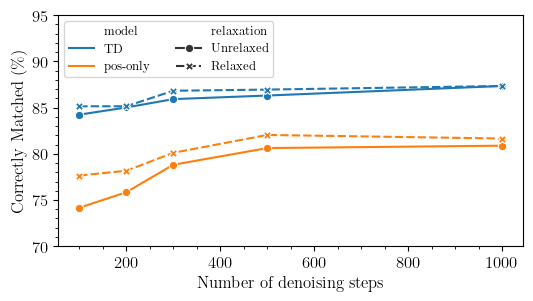

In [36]:
# Reconstructing the plot for the n-steps experiment with labeled models
plt.figure(figsize=(6, 3))

n_steps_labels = [
    *[exp['params']['N_steps'] for exp in experiments['n-steps'] if exp['save_prefix'] == 'pos-only'],
    *[exp['params']['N_steps'] for exp in experiments['n-steps'] if exp['save_prefix'] == 'TD']
]

model_labels = [
    *['pos-only' for exp in experiments['n-steps'] if exp['save_prefix'] == 'pos-only'],
    *['TD' for exp in experiments['n-steps'] if exp['save_prefix'] == 'TD']
]

n_steps_matched_wo_relax = [
    *[exp['correctly_matched'] for exp in experiments['n-steps'] if exp['save_prefix'] == 'pos-only'],
    *[exp['correctly_matched'] for exp in experiments['n-steps'] if exp['save_prefix'] == 'TD']
]
n_steps_matched_w_relax = [
    *[exp['correctly_matched_relaxed'] for exp in experiments['n-steps'] if exp['save_prefix'] == 'pos-only'],
    *[exp['correctly_matched_relaxed'] for exp in experiments['n-steps'] if exp['save_prefix'] == 'TD']
]

n_steps_df = pd.DataFrame({
        'correctly_matched': n_steps_matched_wo_relax,
        'correctly_matched_relaxed': n_steps_matched_w_relax,
        'label': np.array(n_steps_labels).astype(float),
        'model': model_labels
    })
n_steps_df = n_steps_df.melt(
    id_vars=['label', 'model'],
    value_vars=['correctly_matched', 'correctly_matched_relaxed'],
    var_name='relaxation',
    value_name='matched'
)
n_steps_df.sort_values(['model', 'label'], ascending=True, inplace=True)

ax = sns.lineplot(
    data=n_steps_df.replace({
        'correctly_matched': 'Unrelaxed',
        'correctly_matched_relaxed': 'Relaxed',
    }), 
    x='label', y='matched',
    hue='model', style='relaxation',
    sort=True, markers=True
)

sns.move_legend(ax, loc='upper left', ncol=2, title=None)
# plt.legend(ncols=2)
plt.ylabel('Correctly Matched (\%)')
plt.xlabel('Number of denoising steps')
plt.ylim(70, 95)
plt.savefig('./plots/n-steps.pdf', bbox_inches='tight')

## N-Samples-Per-Structure

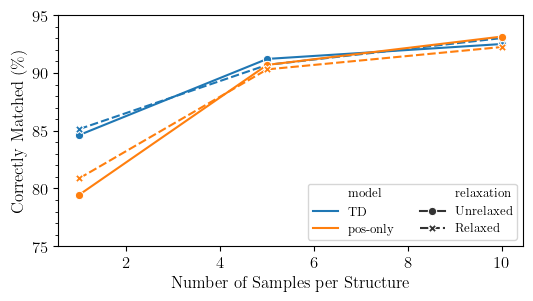

In [40]:
# Updated plot for the n-samples-per-structure experiment with labeled models
plt.figure(figsize=(6, 3))

n_samples_labels = [
    *[exp['params']['N_samples_per_structure'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['params']['N_samples_per_structure'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]

model_labels = [
    *['pos-only' for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *['TD' for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]

n_samples_matched_wo_relax = [
    *[exp['correctly_matched'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['correctly_matched'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]
n_samples_matched_w_relax = [
    *[exp['correctly_matched_relaxed'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['correctly_matched_relaxed'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]

n_samples_df = pd.DataFrame({
        'correctly_matched': n_samples_matched_wo_relax,
        'correctly_matched_relaxed': n_samples_matched_w_relax,
        'label': np.array(n_samples_labels).astype(float),
        'model': model_labels
    })
n_samples_df = n_samples_df.melt(
    id_vars=['label', 'model'],
    value_vars=['correctly_matched', 'correctly_matched_relaxed'],
    var_name='relaxation',
    value_name='matched'
)
n_samples_df.sort_values(['model', 'label'], ascending=True, inplace=True)

ax = sns.lineplot(
    data=n_samples_df.replace({
        'correctly_matched': 'Unrelaxed',
        'correctly_matched_relaxed': 'Relaxed',
    }), x='label', y='matched',
    hue='model', style='relaxation',
    sort=True, markers=True
)
sns.move_legend(ax, loc='lower right', ncol=2, title=None)
plt.gca().tick_params(axis='x', which='minor', bottom=False)
plt.ylabel('Correctly Matched (\%)')
plt.xlabel('Number of Samples per Structure')
plt.ylim(75, 95)
plt.savefig('./plots/n-samples-per-structure.pdf', bbox_inches='tight')

In [41]:
n_samples_labels

['10', '1', '5', '5', '1', '10']

## Can we use the energy to choose the correct prediction among multiple samples

In [42]:
df_energy = pd.read_json(
    '/Users/treents/Documents/Work/PhD/PSI/Mattergen crystal structure inpainting/5-samples-relaxed-orb.json'
    ).dropna()
df_energy.head()

,ref_key,energy,relaxed_energy,match
0,0 - H4 I4 O4 Pb4 - 363,-68.844749,-68.849182,True
1,1 - H5 Ti4 - 82,-51.356525,-51.358681,False
2,2 - Al1 Ca1 H1 Si1 - 70,-16.040947,-16.044289,True
3,3 - H4 Li8 N4 - 136,-70.055023,-70.249146,True
4,4 - H1 Rb1 - 55,-4.637687,-4.637687,True


In [43]:
df_energy['energy_idx'] = (
    df_energy.groupby('ref_key')['energy']
    .rank(method='dense', ascending=True)
    .astype(int) - 1
)
df_energy['relaxed_energy_idx'] = (
    df_energy.groupby('ref_key')['relaxed_energy']
    .rank(method='dense', ascending=True)
    .astype(int) - 1
)

df_energy.sort_values('ref_key').head()

,ref_key,energy,relaxed_energy,match,energy_idx,relaxed_energy_idx
0,0 - H4 I4 O4 Pb4 - 363,-68.844749,-68.849182,True,1,3
1548,0 - H4 I4 O4 Pb4 - 363,-68.840958,-68.849411,True,3,1
2322,0 - H4 I4 O4 Pb4 - 363,-68.819107,-68.849098,True,4,4
774,0 - H4 I4 O4 Pb4 - 363,-68.843903,-68.849274,True,2,2
3096,0 - H4 I4 O4 Pb4 - 363,-68.848816,-68.850014,True,0,0


In [44]:
df_energy_overall_match = df_energy.groupby('ref_key', group_keys=False)[['match']].apply(lambda x: x.sum() > 0)

In [45]:
df_energy_overall_match.mean()

match    0.894057
dtype: float64

In [46]:
keys_wo_any_match = df_energy_overall_match.query('~match').index.to_list()
keys_w_any_match = df_energy_overall_match.query('match').index.to_list()

In [47]:
df_sampled = df_energy.groupby('ref_key', group_keys=False).apply(lambda x: x.sample(1))

print('Matches when randomly sampling one observation')
print( 
    f'Correctly matched: {df_sampled["match"].mean():.2%} ',
)

Matches when randomly sampling one observation
Correctly matched: 83.07% 


In [48]:
df_min_energy = df_energy.query('energy_idx == 0')
matches_not_0 = df_min_energy.query('not match')['ref_key'].to_list()
df_min_energy_relaxed = df_energy.query('relaxed_energy_idx == 0')

print('Matches after selecting minimum energy configuration')
print(
    f'Correctly matched: {df_min_energy["match"].mean():.2%}',
    f'Correctly matched (relaxed): {df_min_energy_relaxed["match"].mean():.2%}',
    sep='\n'
)

Matches after selecting minimum energy configuration
Correctly matched: 87.48%
Correctly matched (relaxed): 87.00%


In [49]:
df_energy[df_energy['ref_key'].isin(set(matches_not_0) & set(keys_w_any_match))].sort_values('ref_key')

,ref_key,energy,relaxed_energy,match,energy_idx,relaxed_energy_idx
1729,181 - H8 K4 Pt2 - 262,-49.218723,-49.248032,True,2,2
181,181 - H8 K4 Pt2 - 262,-49.240036,-49.256115,False,0,0
2503,181 - H8 K4 Pt2 - 262,-47.374702,-48.687988,False,4,4
955,181 - H8 K4 Pt2 - 262,-49.111023,-49.143974,False,3,3
3277,181 - H8 K4 Pt2 - 262,-49.238022,-49.255581,False,1,1
...,...,...,...,...,...,...
82,82 - H8 - 126,-27.041100,-27.050354,True,2,2
1630,82 - H8 - 126,-27.025093,-27.047215,True,3,3
856,82 - H8 - 126,-27.050224,-27.051094,False,0,0
2404,82 - H8 - 126,-27.049194,-27.050537,False,1,1


## Compare n-steps and n-samples

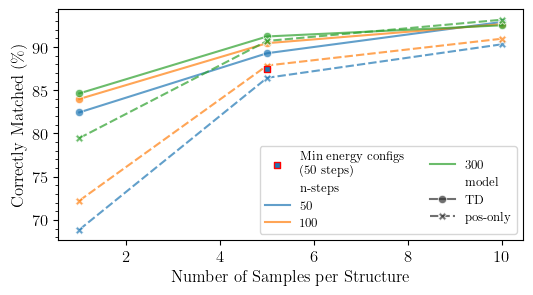

In [52]:
# Updated plot for the n-samples-per-structure experiment with labeled models
plt.figure(figsize=(6, 3))

n_samples_labels = [
    *[exp['params']['N_samples_per_structure'] for exp in experiments['50-steps'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['params']['N_samples_per_structure'] for exp in experiments['50-steps'] if exp['save_prefix'].startswith('TD')],
    *[exp['params']['N_samples_per_structure'] for exp in experiments['100-steps'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['params']['N_samples_per_structure'] for exp in experiments['100-steps'] if exp['save_prefix'].startswith('TD')],
    *[exp['params']['N_samples_per_structure'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['params']['N_samples_per_structure'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]

model_labels = [
    *['pos-only' for exp in experiments['50-steps'] if exp['save_prefix'].startswith('pos-only')],
    *['TD' for exp in experiments['50-steps'] if exp['save_prefix'].startswith('TD')],
    *['pos-only' for exp in experiments['100-steps'] if exp['save_prefix'].startswith('pos-only')],
    *['TD' for exp in experiments['100-steps'] if exp['save_prefix'].startswith('TD')],
    *['pos-only' for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *['TD' for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]

n_steps_labels = [
    *[exp['params']['N_steps'] for exp in experiments['50-steps'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['params']['N_steps'] for exp in experiments['50-steps'] if exp['save_prefix'].startswith('TD')],
    *[exp['params']['N_steps'] for exp in experiments['100-steps'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['params']['N_steps'] for exp in experiments['100-steps'] if exp['save_prefix'].startswith('TD')],
    *[exp['params']['N_steps'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['params']['N_steps'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]

n_samples_matched_wo_relax = [
    *[exp['correctly_matched'] for exp in experiments['50-steps'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['correctly_matched'] for exp in experiments['50-steps'] if exp['save_prefix'].startswith('TD')],
    *[exp['correctly_matched'] for exp in experiments['100-steps'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['correctly_matched'] for exp in experiments['100-steps'] if exp['save_prefix'].startswith('TD')],
    *[exp['correctly_matched'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['correctly_matched'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]
n_samples_matched_w_relax = [
    *[exp['correctly_matched_relaxed'] for exp in experiments['50-steps'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['correctly_matched_relaxed'] for exp in experiments['50-steps'] if exp['save_prefix'].startswith('TD')],
    *[exp['correctly_matched_relaxed'] for exp in experiments['100-steps'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['correctly_matched_relaxed'] for exp in experiments['100-steps'] if exp['save_prefix'].startswith('TD')],
    *[exp['correctly_matched_relaxed'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('pos-only')],
    *[exp['correctly_matched_relaxed'] for exp in experiments['n-samples-per-structure'] if exp['save_prefix'].startswith('TD')],
]

n_samples_df = pd.DataFrame({
        'correctly_matched': n_samples_matched_wo_relax,
        'correctly_matched_relaxed': n_samples_matched_w_relax,
        'label': np.array(n_samples_labels).astype(float),
        'model': model_labels,
        'n-steps': n_steps_labels
    })
n_samples_df = n_samples_df.melt(
    id_vars=['label', 'model', 'n-steps'],
    value_vars=['correctly_matched', 'correctly_matched_relaxed'],
    var_name='relaxation',
    value_name='matched'
)
n_samples_df.sort_values(['model', 'label'], ascending=True, inplace=True)

plt.scatter(
    5, df_min_energy["match"].mean() * 100, marker='s', 
    color='tab:blue', s=13, zorder=10, label='Min energy configs\n(50 steps)', edgecolors='red'
    )
sns.lineplot(
    data=n_samples_df.query('relaxation == "correctly_matched"').replace({
        'correctly_matched': 'Unrelaxed',
        'correctly_matched_relaxed': 'Relaxed',
    }), 
    x='label', y='matched',
    style='model', hue='n-steps',
    sort=True, markers=True,
    alpha=0.7
)

plt.legend(ncols=2)
plt.gca().tick_params(axis='x', which='minor', bottom=False)
plt.ylabel('Correctly Matched (\%)')
plt.xlabel('Number of Samples per Structure')
# plt.ylim(75, 95)
plt.savefig('./plots/n-samples-per-structure-min-energy.pdf', bbox_inches='tight')